# LangGraph - Complete Implementation Guide

## Overview

**LangGraph** is a low-level orchestration framework for building, managing, and deploying long-running, stateful AI agents. Released as version 1.0 in October 2025, it provides the infrastructure for building production-ready agent systems with comprehensive memory, human-in-the-loop capabilities, and durable execution.

## Table of Contents

1. [What's New in LangChain v0.3](#whats-new-in-langchain-v3)
2. [Architecture Changes](#architecture-changes)
3. [Package Structure](#package-structure)
4. [Migration Guide](#migration-guide)
5. [Key Features](#key-features)


### Core Changes

**1. Agent Implementation on LangGraph**
- The new `create_agent` implementation is built on top of LangGraph
- Takes advantage of the underlying agent runtime
- Same high-level interface, different underpinning
- Battle-tested in production by companies like Uber, LinkedIn, and Klarna

**2. Pydantic 2 Migration**
- Full upgrade from Pydantic 1 to Pydantic 2 internally
- Pydantic 1 support dropped (reached end-of-life June 2024)
- No need for bridges like `langchain_core.pydantic_v1`

**3. Python Version Requirements**
- Python 3.8 no longer supported (end-of-life October 2024)
- Minimum Python version: 3.9+

## Core Concepts

### What is LangGraph?

LangGraph provides:

1. **Durable Execution**: Agents persist through failures and resume automatically
2. **Human-in-the-Loop**: Inspect and modify agent state at any point
3. **Comprehensive Memory**: Short-term and long-term persistent memory
4. **Stateful Workflows**: Build complex, stateful agent architectures
5. **Production-Ready**: Scalable infrastructure for production deployment

### Key Benefits

```bash
# LangGraph doesn't abstract prompts or architecture
# You have full control over:
- Agent decision-making logic
- State management
- Tool calling patterns
- Memory strategies
- Human intervention points
```

## Quick Start

### Installation

```bash
# Basic installation
pip install langgraph

# With checkpointing support
pip install langgraph langgraph-checkpoint-postgres

# Full installation with extras
pip install "langgraph[postgres]"
```

## Architecture

### Graph-Based Design

LangGraph uses a graph structure where:
- **Nodes** represent processing steps (functions)
- **Edges** represent data flow between nodes
- **State** is shared across all nodes

In [1]:
# Create a secret openai key input in jupyter notebook
import os
from getpass import getpass

# Securely input OpenAI API key
if "OPENAI_API_KEY" not in os.environ:
    os.environ["OPENAI_API_KEY"] = getpass("Enter your OpenAI API key: ")

In [2]:
from langgraph.graph import StateGraph, MessagesState, START, END


def mock_llm(state: MessagesState):
    return {"messages": [{"role": "ai", "content": "hello world"}]}


graph = StateGraph(MessagesState)
graph.add_node(mock_llm)
graph.add_edge(START, "mock_llm")
graph.add_edge("mock_llm", END)
graph = graph.compile()

graph.invoke({"messages": [{"role": "user", "content": "hi!"}]})

{'messages': [HumanMessage(content='hi!', additional_kwargs={}, response_metadata={}, id='63401bb9-094b-45b7-8fa7-fc550828e275'),
  AIMessage(content='hello world', additional_kwargs={}, response_metadata={}, id='b25b4f39-7932-48e6-ab03-83f255cf5ad9')]}

### Step 0: Define tools and model

In [3]:
from langchain_core.tools import tool
from langchain.chat_models import init_chat_model

llm = init_chat_model("openai:o4-mini")


# Define tools
@tool
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b


@tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b


@tool
def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b


# Augment the LLM with tools
tools = [add, multiply, divide]
tools_by_name = {tool.name: tool for tool in tools}
llm_with_tools = llm.bind_tools(tools)

In [4]:
tools_by_name

{'add': StructuredTool(name='add', description='Adds a and b.\n\n    Args:\n        a: first int\n        b: second int', args_schema=<class 'langchain_core.utils.pydantic.add'>, func=<function add at 0x7c5cfe81ba60>),
 'multiply': StructuredTool(name='multiply', description='Multiply a and b.\n\n    Args:\n        a: first int\n        b: second int', args_schema=<class 'langchain_core.utils.pydantic.multiply'>, func=<function multiply at 0x7c5cffa92ac0>),
 'divide': StructuredTool(name='divide', description='Divide a and b.\n\n    Args:\n        a: first int\n        b: second int', args_schema=<class 'langchain_core.utils.pydantic.divide'>, func=<function divide at 0x7c5cfe7eb740>)}

In [5]:
llm_with_tools

RunnableBinding(bound=ChatOpenAI(client=<openai.resources.chat.completions.completions.Completions object at 0x7c5cfed87410>, async_client=<openai.resources.chat.completions.completions.AsyncCompletions object at 0x7c5cfe80bd40>, root_client=<openai.OpenAI object at 0x7c5cff659fa0>, root_async_client=<openai.AsyncOpenAI object at 0x7c5cfec6de20>, model_name='o4-mini', model_kwargs={}, openai_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'add', 'description': 'Adds a and b.\n\n    Args:\n        a: first int\n        b: second int', 'parameters': {'properties': {'a': {'type': 'integer'}, 'b': {'type': 'integer'}}, 'required': ['a', 'b'], 'type': 'object'}}}, {'type': 'function', 'function': {'name': 'multiply', 'description': 'Multiply a and b.\n\n    Args:\n        a: first int\n        b: second int', 'parameters': {'properties': {'a': {'type': 'integer'}, 'b': {'type': 'integer'}}, 'required': ['a', 'b'], 'type': 'object'}}}, {'type': '

### Step 1: Define state

In [6]:
from langchain_core.messages import AnyMessage
from typing_extensions import TypedDict, Annotated
import operator


class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]
    llm_calls: int

### Step 2: Define model node

In [7]:
from langchain_core.messages import SystemMessage


def llm_call(state: dict):
    """LLM decides whether to call a tool or not"""

    return {
        "messages": [
            llm_with_tools.invoke(
                [
                    SystemMessage(
                        content="You are a helpful assistant tasked with performing arithmetic on a set of inputs."
                    )
                ]
                + state["messages"]
            )
        ],
        "llm_calls": state.get("llm_calls", 0) + 1,
    }

In [8]:
ans = llm_call({"messages": [{"role": "user", "content": "What is north?"}]})


In [9]:
ans

{'messages': [AIMessage(content='North is one of the four primary (cardinal) compass directions. Here are a few ways to think about it:\n\n1. Geographic North  \n   – It points toward Earth’s North Pole, the point where the planet’s axis of rotation meets its surface in the Northern Hemisphere.  \n   – On most maps (in Western cartography), north is oriented “up.”  \n\n2. Magnetic North  \n   – A compass needle actually aligns with Earth’s magnetic field, pointing toward what’s called Magnetic North.  \n   – Magnetic North moves slightly over time due to changes in Earth’s core.  \n\n3. Usage  \n   – Navigation: “Head north” means to travel toward higher latitudes (toward the Pole).  \n   – Orientation: If you stand facing north, east will be on your right, west on your left, and south directly behind you.  \n\nIn everyday life, knowing where north is lets you orient maps, plan routes, and understand how the Sun’s path changes with the seasons (it rises generally in the east and sets i

### Step 3: Define tool node

In [10]:
from langchain_core.messages import ToolMessage


def tool_node(state: dict):
    """Performs the tool call"""

    result = []
    for tool_call in state["messages"][-1].tool_calls:
        tool = tools_by_name[tool_call["name"]]
        observation = tool.invoke(tool_call["args"])
        result.append(ToolMessage(content=observation, tool_call_id=tool_call["id"]))
    return {"messages": result}

In [11]:
tool_node({"messages": ans["messages"]})

{'messages': []}

### Step 4: Define logic to determine whether to end

In [12]:
from typing import Literal
from langgraph.graph import StateGraph, START, END


# Conditional edge function to route to the tool node or end 
# based upon whether the LLM made a tool call
def should_continue(state: MessagesState) -> Literal["tool_node", END]:
    """Decide if we should continue the loop or stop based upon whether the LLM made a tool call"""

    messages = state["messages"]
    last_message = messages[-1]
    # If the LLM makes a tool call, then perform an action
    if last_message.tool_calls:
        return "tool_node"
    # Otherwise, we stop (reply to the user)
    return END

In [13]:
should_continue({"messages": ans["messages"]})

'__end__'

### Step 5: Build agent

In [14]:
# Build workflow
agent_builder = StateGraph(MessagesState)

# Add nodes
agent_builder.add_node("llm_call", llm_call)
agent_builder.add_node("tool_node", tool_node)

# Add edges to connect nodes
agent_builder.add_edge(START, "llm_call")
agent_builder.add_conditional_edges("llm_call", should_continue, ["tool_node", END])
agent_builder.add_edge("tool_node", "llm_call")

# Compile the agent
agent = agent_builder.compile()

### Visualize the agent

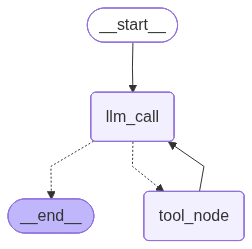

In [15]:
from IPython.display import Image, display

display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

### Invoke the agent

In [16]:
from langchain_core.messages import HumanMessage

messages = [HumanMessage(content="Add 3 and 4.")]
messages = agent.invoke({"messages": messages})
for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================
Tool Calls:
  add (call_pAtRZOd2e9yhPNlnsM7m6AFz)
 Call ID: call_pAtRZOd2e9yhPNlnsM7m6AFz
  Args:
    a: 3
    b: 4
================================= Tool Message =================================

7
================================== Ai Message ==================================

The sum of 3 and 4 is 7.


In [17]:
# Step 0: Define tools and model

from langchain_core.tools import tool
from langchain.chat_models import init_chat_model

# Define tools
@tool
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b


@tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b


@tool
def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b


# Augment the LLM with tools
tools = [add, multiply, divide]
tools_by_name = {tool.name: tool for tool in tools}
llm_with_tools = llm.bind_tools(tools)

from langgraph.graph import add_messages
from langchain_core.messages import (
    SystemMessage,
    HumanMessage,
    BaseMessage,
    ToolCall,
)
from langgraph.func import entrypoint, task


# Step 1: define model node
@task
def call_llm(messages: list[BaseMessage]):
    """LLM decides whether to call a tool or not"""
    return llm_with_tools.invoke(
        [
            SystemMessage(
                content="You are a helpful assistant tasked with performing arithmetic on a set of inputs."
            )
        ]
        + messages
    )


# Step 2: define tool node
@task
def call_tool(tool_call: ToolCall):
    """Performs the tool call"""
    tool = tools_by_name[tool_call["name"]]
    return tool.invoke(tool_call)


# Step 3: define agent
@entrypoint()
def agent(messages: list[BaseMessage]):
    llm_response = call_llm(messages).result()

    while True:
        if not llm_response.tool_calls:
            break

        # Execute tools
        tool_result_futures = [
            call_tool(tool_call) for tool_call in llm_response.tool_calls
        ]
        tool_results = [fut.result() for fut in tool_result_futures]
        messages = add_messages(messages, [llm_response, *tool_results])
        llm_response = call_llm(messages).result()

    messages = add_messages(messages, llm_response)
    return messages


# Invoke
messages = [HumanMessage(content="Add 3 and 4.")]
for chunk in agent.stream(messages, stream_mode="updates"):
    print(chunk)
    print("\n")

{'call_llm': AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_RUW4Mx1inY2aQmgUP69mtYkE', 'function': {'arguments': '{"a":3,"b":4}', 'name': 'add'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 90, 'prompt_tokens': 153, 'total_tokens': 243, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 64, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'o4-mini-2025-04-16', 'system_fingerprint': None, 'id': 'chatcmpl-CMDvzXhvRN8GidDbj4AfFL94c2uuS', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--3bd9aec1-c168-4acc-a9ad-7ab28fa419b6-0', tool_calls=[{'name': 'add', 'args': {'a': 3, 'b': 4}, 'id': 'call_RUW4Mx1inY2aQmgUP69mtYkE', 'type': 'tool_call'}], usage_metadata={'input_tokens': 153, 'output_tokens': 90, 'total_tokens': 243, 'input_token_details': {'audio': 0, 'cache_read'